# Implementing encoder

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

In [3]:
# Load MNIST dataset
DATA_PATH = '../data'
data = np.load(DATA_PATH+'/images.npy')
label = np.load(DATA_PATH+'/labels.npy')

In [4]:
label[490:510]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False])

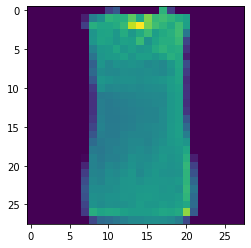

In [5]:
plt.imshow(data[200,:,:])

In [6]:
data_reduced = data.reshape((len(data),28*28))[490:510]
data_reduced.shape

(20, 784)

In [7]:
ss = StandardScaler()
sample_train = ss.fit_transform(data_reduced)
# Reduce dimensions
N_DIM = 8
pca = PCA(n_components=N_DIM)
data_reduced = pca.fit_transform(data_reduced)

#mms = MinMaxScaler((-1, 1))
#ata_reduced = mms.fit_transform(data_reduced)

In [8]:
data_reduced.shape

(20, 8)

In [9]:
label = label[490:510]

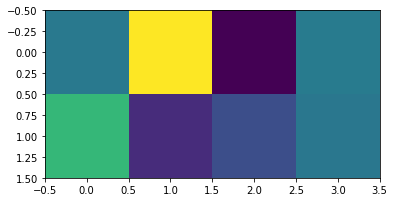

In [10]:
first = data_reduced[0]
#plt.imshow(first.reshape(int(np.sqrt(N_DIM)),int(np.sqrt(N_DIM))))
plt.imshow(first.reshape(2,4))

In [11]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [12]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [13]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [14]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    #initial_point=initial_point,
)

In [15]:
type(classifier)

qiskit_machine_learning.algorithms.classifiers.neural_network_classifier.NeuralNetworkClassifier

In [16]:
data_reduced[0]

array([ 0.00367824,  0.02679043, -0.01201748,  0.00407763,  0.01378817,
       -0.00704968, -0.00274873,  0.00335775])

In [17]:
label.astype(int)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
x = data_reduced
y = label.astype(int)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
#print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "/Users/emiliano_gr/opt/anaconda3/envs/app_qc/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py", line 261, in calcfc
    f = fun(np.copy(x), *args)
  File "/Users/emiliano_gr/opt/anaconda3/envs/app_qc/lib/python3.10/site-packages/qiskit_machine_learning/algorithms/trainable_model.py", line 276, in objective
    self._callback(objective_weights, objective_value)
  File "/var/folders/_n/xw2mchz92t9_fcbxg7lwsdwh0000gn/T/ipykernel_54558/1393515284.py", line 2, in callback_graph
NameError: name 'clear_output' is not defined

Extension modules: zmq.backend.cython.constants, zmq.backend.cython.error, zmq.backend.cython.message, zmq.backend.cython.context, zmq.backend.cython.socket

: 

: 